# Anomaly Detection On Qatar Airways Reviews

In [ ]:
%pip install kagglehub[pandas-datasets] scikit-learn pandas seaborn

Note: you may need to restart the kernel to use updated packages.


## Import Review Dataset

In [66]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
# Set the path to the file you'd like to load
file_path = "qatar_airways_reviews.csv"

# Load the latest version
qar_df_raw = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "pranaybshah/qatar-airways-reviews",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

### Data Cleaning

In [67]:
# clean_data
# Filter rows based on column: 'Route'
qar_df = qar_df_raw[qar_df_raw['Route'].notna()]
# Filter rows based on column: 'Rating'
qar_df = qar_df[qar_df['Rating'].notna()]
# Rename column: 'Unnamed: 0' to 'review_id'
qar_df = qar_df.rename(columns={'Unnamed: 0': 'review_id'})
# Filter rows based on column: 'Verified'
qar_df = qar_df[(qar_df['Verified'].notna()) & (qar_df['Verified'] == 1)]
# Modify the Rating column to be between 0 and 1 by dividing by 10
qar_df['Rating'] = qar_df['Rating'] / 10

In [68]:
qar_df.head(5)

,review_id,Date Published,Rating,Max Rating,Title,Author,Country,Date,Review Body,Type Of Traveller,Seat Type,Route,Date Flown,Recommended,Aircraft,Verified
1,1,2024-02-29,0.1,10.0,"""seat wouldn't stay up""",Brian English,Canada,2024-02-29,They convinced me that I needed to pay $1500...,Couple Leisure,Business Class,Doha to Montreal,February 2024,no,NaN,1.0
2,2,2024-02-29,0.1,10.0,"""no attempt to address our complaint""",Wayne Burgess,Australia,2024-02-29,I have sent 5 emails and have only received ...,Business,Economy Class,Doha to Perth,November 2023,no,A380,1.0
3,3,2024-02-25,1.0,10.0,“I hope they update the A380”,Alwaleed Althani,Qatar,2024-02-25,We flew on probably the first A380 the airlin...,Couple Leisure,First Class,Doha to London Heathrow,February 2024,NaN,A380-800,1.0
4,4,2024-02-22,0.7,10.0,"""I’d rate them maybe 7/10""",W Warnock,United Kingdom,2024-02-22,"Service was ok, pretty good on my aisle and ...",Couple Leisure,Business Class,Auckland to Doha,February 2024,no,A350,1.0
5,5,2024-02-20,1.0,10.0,"""remarkable experience""",Qandeel Ahtasham,United Kingdom,2024-02-20,12th February 2024 From check in to get onboa...,Family Leisure,Business Class,Doha to London,February 2024,NaN,A380,1.0


### Aggregate Time-series DataFrame

In [ ]:
# Create a time-series of the average rating by year-month-week. Also create a column called "review_ids" which conatins an aggregated list of review_ids for each time period.
qar_ts_df = qar_df.copy()
qar_ts_df['Date'] = pd.to_datetime(qar_ts_df['Date'])
qar_ts_df['YearMonthWeek'] = qar_ts_df['Date'].dt.strftime('%Y-%m-%U')
qar_ts_df['YearMonth'] = qar_ts_df['Date'].dt.strftime('%Y-%m')
# select time series columns
qar_ts_df['ts'] = qar_ts_df['YearMonth']

qar_ts_df['review_ids'] = qar_ts_df['review_id'].apply(lambda x: [x])
qar_ts_df = qar_ts_df.groupby('ts').agg({'Rating': 'mean', 'review_ids': 'sum'}).reset_index()
# creat a new column 'review_count' which contains the count of reviews in each time period
qar_ts_df['review_count'] = qar_ts_df['review_ids'].apply(lambda x: len(x))
# combine Rating and review_count into an array column aggregated column called 'rating_and_review_count'
qar_ts_df['rating_and_review_count'] = qar_ts_df[['Rating', 'review_count']].apply(lambda x: [x['Rating'], x['review_count']], axis=1)
qar_ts_df.shape

(76, 5)

In [70]:
qar_ts_df.head(5)

,ts,Rating,review_ids,review_count,rating_and_review_count
0,2017-11,0.784615,"[1241, 1242, 1243, 1244, 1245, 1246, 1247, 124...",13,"[0.7846153846153846, 13.0]"
1,2017-12,0.740909,"[1219, 1220, 1221, 1222, 1223, 1224, 1225, 122...",22,"[0.740909090909091, 22.0]"
2,2018-01,0.811111,"[1201, 1202, 1203, 1204, 1205, 1206, 1207, 120...",18,"[0.8111111111111111, 18.0]"
3,2018-02,0.693333,"[1186, 1187, 1188, 1189, 1190, 1191, 1192, 119...",15,"[0.6933333333333334, 15.0]"
4,2018-03,0.691304,"[1163, 1164, 1165, 1166, 1167, 1168, 1169, 117...",23,"[0.691304347826087, 23.0]"


## Detectors

### Standard Deviation from Median (Baseline Method)
Type of anomalies: Point anomalies (global outliers). This is a simple statistical rule: any data point deviating from the median by more than a certain number of standard deviations is flagged as an anomaly. This method assumes a roughly stable distribution of values.

- How it works: Calculate the median of the time-series and its standard deviation. Any point `x` for which `|x – median|` exceeds a threshold (e.g., k standard deviations) is marked anomalous. The anomaly "score" can be the z-score relative to the median (how many std dev away the point is). A common choice is k = 3, following the “3-sigma rule” which flags roughly the most extreme 0.3% of normally distributed data​. 
via [ codefinity.com](https://codefinity.com/courses/v2/165dbadd-b48e-4a7f-8b0d-1b8477c22a1d/047e166d-bc62-4bd1-8114-f0771ef62d83/a087d692-2177-4251-ac77-9466243454e4)

- Sensitivity tuning: The threshold k is the main sensitivity parameter. A lower k (e.g. 2) makes the detector more sensitive (flags more points as anomalies), while a higher k (e.g. 4 or 5) makes it less sensitive. Users can adjust k to trade off false positives vs. false negatives.
Output: Each flagged point is an anomaly. The certainty score can be the z-score (e.g. 3.5 means the point is 3.5 standard deviations from the median), indicating how extreme it is.


Pros:
- Extremely simple and fast (just one pass to compute median and std, and another to check thresholds).
- No training needed; works well when data is mostly stationary (no strong trend/seasonality).
- Threshold k is intuitive to adjust.

Cons:
- Not context-aware (does not account for trend or seasonality), so it may miss contextual anomalies or flag normal seasonal peaks as outliers.
- Assumes data variability can be captured by a single global standard deviation (not robust if distribution is skewed or heavy-tailed).
- Cannot directly detect collective anomalies (only individual points).

In [72]:

def std_from_median_detector(series, k=3):
    series = np.asarray(series)
    median = np.median(series)
    std = np.std(series)
    # Compute z-scores relative to median
    z_scores = np.abs((series - median) / std)
    # Anomalies where z-score > k
    anomaly_indices = np.where(z_scores > k)[0]
    # print(f"Median: {median}, Standard deviation: {std}")
    # print(f"Anomaly indices: {anomaly_indices}")
    # Return anomaly indices and their z-scores as "certainty" scores
    return anomaly_indices, z_scores[anomaly_indices]

# Detect anomalies in the time-series data
# On the average rating
std_anomaly_indices, std_anomaly_scores = std_from_median_detector(qar_ts_df['Rating'], k=2)
print(f"Anomaly indices: {std_anomaly_indices}")
print(f"Anomaly scores: {std_anomaly_scores}")

Anomaly indices: [29 30 39 41]
Anomaly scores: [2.14501433 2.29490466 2.41481692 2.14501433]


### Isolation Forest (Ensemble Trees)
Type of anomalies: Primarily point anomalies (global or local outliers). Isolation Forest is an unsupervised algorithm that works by randomly partitioning the data. It builds an ensemble of random decision trees that isolate observations; anomalies tend to be isolated in fewer splits (shorter tree path) than normal points​.
via - [scikit-learn](https://scikit-learn.org/stable/modules/outlier_detection.html)

- How it works: The algorithm randomly splits data along feature values; outliers, being "few and different," are isolated quickly. The average path length for a point across many random trees becomes an anomaly score – shorter paths imply more anomalous​
SCIKIT-LEARN.ORG. In a time-series context, you can apply Isolation Forest on the sequence of values (and potentially additional contextual features like time-of-day if needed). It does not explicitly use time order, but it will detect points that are statistically isolated in the value space.

- Sensitivity tuning: The key parameter is contamination (the proportion of data expected to be anomalies). This controls the threshold on the anomaly score; e.g., contamination=0.01 means the 1% most extreme points are flagged. Lowering contamination makes the detector more selective (fewer anomalies, higher precision), while increasing it catches more anomalies (but could include more false alarms). Other parameters include n_estimators (number of trees) and max_samples, but these affect performance and stability rather than sensitivity. The default settings often work well in practice​
SPOTINTELLIGENCE.COM.

- Output: For each point, IsolationForest provides a score (via score_samples or decision_function). By default, points with scores below a threshold are predicted as anomalies (-1 label). Typically the score is normalized such that negative scores indicate anomalies. You can interpret the certainty as the magnitude by which the score falls below 0 or compare relative scores – a very low score means the algorithm is quite confident that point is anomalous.

Pros:
- Fast and scalable to high-dimensional data​. Runs in roughly linear time with number of samples. Suitable for real-time APIs.
- No assumption of data distribution; can detect anomalies in complex, non-Gaussian data​
NEPTUNE.AI.
- Few hyperparameters and often works well with defaults (making it easy to use)​
SPOTINTELLIGENCE.COM.
- Returns a natural anomaly score (based on path length) for each point.

Cons:
- Not inherently aware of temporal context – it treats the series as a set of points. If the series has seasonality or trend, those need to be accounted for (e.g., detrending first or adding time features) to detect contextual anomalies properly.
- It identifies individual anomalous points; a sudden shift (collective anomaly) may result in many points flagged individually rather than a single grouped event.
- Minor randomness (due to random splits), but using enough trees or setting a random seed can mitigate variability.

In [73]:
from sklearn.ensemble import IsolationForest

def isolation_forest_detector(series, n_estimators=100, contamination='auto', random_state=42):
    # Detect anomalies in a 1D time series array `series`
    model = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=random_state)    
    # Reshape the series to be 2D
    # model.fit(series.reshape(-1, 1))
    model.fit(series)
    labels = model.predict(series)        # 1 for inliers, -1 for anomalies
    scores = model.decision_function(series)  # anomaly score (higher = more normal)
    # Invert scores for a more intuitive "anomaly severity" measure
    anomaly_scores = -scores

    # Indices of anomalies:
    anomaly_indices = np.where(labels == -1)[0]
    # Certainty scores for anomalies:
    anomaly_certainties = anomaly_scores[anomaly_indices]
    return anomaly_indices, anomaly_certainties

# Detect anomalies in the time-series data
# On the average rating
if_anomaly_indices, if_anomaly_scores = isolation_forest_detector(qar_ts_df[['Rating', 'review_count']].values, n_estimators=100, contamination=0.04, random_state=42)
print(f"Anomaly indices: {if_anomaly_indices}")
print(f"Anomaly scores: {if_anomaly_scores}")


Anomaly indices: [29 56 59]
Anomaly scores: [0.07521181 0.08947861 0.08284315]


/tmp/ipykernel_21915/1940484027.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


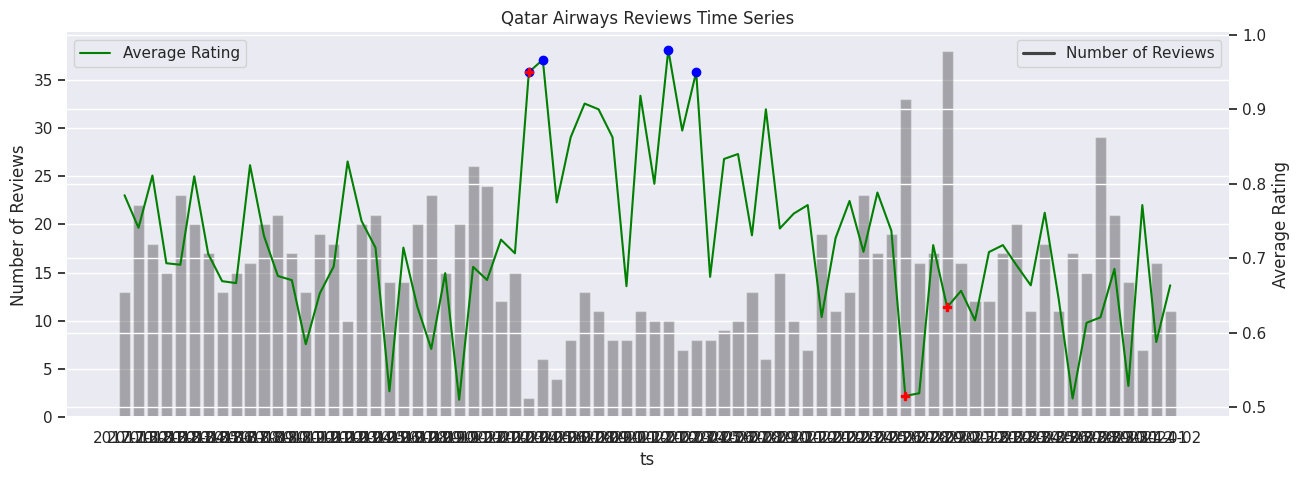

In [ ]:
# plot the time-series data
# plot both the average rating(blue) and number of reviews(green) in each time period
# highlight the anomalies for each detector for the average rating with red color
# plot number of reviews as a bar plot
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 5)})
ax2 = sns.barplot(x='ts', y='review_count', data=qar_ts_df, color='black', alpha=0.3)
ax = ax2.twinx()
ax = sns.lineplot(x='ts', y='Rating', data=qar_ts_df, color='green')
ax.set_ylabel('Average Rating')
ax.set_xlabel('Year-Month-Week')
ax2.set_ylabel('Number of Reviews')
for anomaly_index, marker_prop in [(std_anomaly_indices, {"color":'blue', "marker": 'o', "linestyle":"None"}), (if_anomaly_indices, {"color":'red', "marker": 'P', "linestyle":"None"})]:
    # show as red dots
    ax.plot(qar_ts_df.iloc[anomaly_index]['ts'], qar_ts_df.iloc[anomaly_index]['Rating'], **marker_prop)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title('Qatar Airways Reviews Time Series')
ax.legend(['Average Rating'], loc='upper left')
ax2.legend(['Number of Reviews'], loc='upper right')
sns.despine()
